<a href="https://colab.research.google.com/github/harishmuh/machine_learning_practices/blob/main/Simple_linear_regression_Horsepower_mpg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **`Simple Linear Regression - Exercise`**

---

### **Contents**

0. Initial Setup
1. Business Problem Understanding
2. Data Understanding
3. Data Preprocessing
4. Modeling
5. Conclusion
6. Recommendation

### `Initial Setup`

In [1]:
# Import library for data exploration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

# Import library modeling
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, root_mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### `Business Problem Understanding`

**Context**

MPG is a standard metric used to measure a vehicle's fuel efficiency, representing the distance traveled per unit of fuel used. Accurate prediction of fuel consumption can help optimize fuel use, reduce costs, and mitigate environmental impact.

**Problem Statement**

The challenge is to develop an accurate predictive model that estimates fuel consumption based on horsepower for various vehicle types.

**Goals**

Determine the appropriate fuel consumption (mpg) for each vehicle based on its horsepower.

**Analytic Approach**

Therefore, we need to build a regression model that will help companies provide a fuel consumption prediction tool based on horsepower, which can help optimize fuel efficiency while maintaining the desired level of performance.

**Metric Evaluation**

The evaluation metrics that will be used are MSE and RMSE. The smaller the values ​​of both, the more accurate the model is in predicting fuel consumption within the limitations of the features used.

Additionally, we can derive the R-squared or adj. R-squared value to determine how well the model represents the overall variance of the data. The closer it is to 1, the better the model fits the observed data. However, this metric is not valid for non-linear models.

### `Data Understanding`

In [2]:
# Load dataset
data = sns.load_dataset('mpg')[['horsepower', 'mpg']] # Only 2 columns extracted
print(f'Number of rows and columns: {data.shape}')

data.head()

Number of rows and columns: (398, 2)


,horsepower,mpg
0,130.0,18.0
1,165.0,15.0
2,150.0,18.0
3,150.0,16.0
4,140.0,17.0


======================================

| Features | Description |
|-|-|
| `horsepower` | The car's engine power in hp|

======================================

| Target | Description |
|-|-|
| `mpg` | Fuel consumption in miles per gallon |

`Initial Assesment`

In [3]:
# Check descriptive statistics
data.describe()

,horsepower,mpg
count,392.000000,398.000000
mean,104.469388,23.514573
std,38.491160,7.815984
min,46.000000,9.000000
25%,75.000000,17.500000
50%,93.500000,23.000000
75%,126.000000,29.000000
max,230.000000,46.600000


In [5]:
# Check the data type, null values, and unique values ​​of each column
pd.DataFrame({
  'feature': data.columns.values,
  'data_type': data.dtypes.values,
  'null': data.isna().mean().values * 100,
  'negative': [True if data[col].dtype == int and (data[col] < 0).any() else False for col in data.columns],
  'n_unique': data.nunique().values,
  'sample_unique': [data[col].unique() for col in data.columns]
})

,feature,data_type,null,negative,n_unique,sample_unique
0,horsepower,float64,1.507538,False,93,"[130.0, 165.0, 150.0, 140.0, 198.0, 220.0, 215..."
1,mpg,float64,0.000000,False,129,"[18.0, 15.0, 16.0, 17.0, 14.0, 24.0, 22.0, 21...."


**Insight**

- The dataset consists of 398 rows and 2 columns.
- Horsepower ranges from 46 to 230 hp.
- There are 1.5% missing values ​​in the horsepower column.

`Data Distribution`

In [8]:
def plot_distribution(column):
    fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (7.5,5),
                                    gridspec_kw={"height_ratios": (.15, .85),
                                                "hspace": 0.05})

    stat, pvalue = shapiro(data[column].dropna())

    if pvalue > 0.05 :
        normality = f'pvalue = {pvalue:.3f}, Data is normally distributed'
    else :
        normality = f'pvalue = {pvalue:.3f}, Data is not normally distributed'

    ax1.set_title(f"Data distribution of {column}\n{normality}", color = "black")
    sns.boxplot(x = data[column], ax = ax1)
    ax1.set(xlabel = "")

    sns.histplot(data = data[column], ax = ax2, stat = "probability", kde=True, bins=50)

    plt.show()

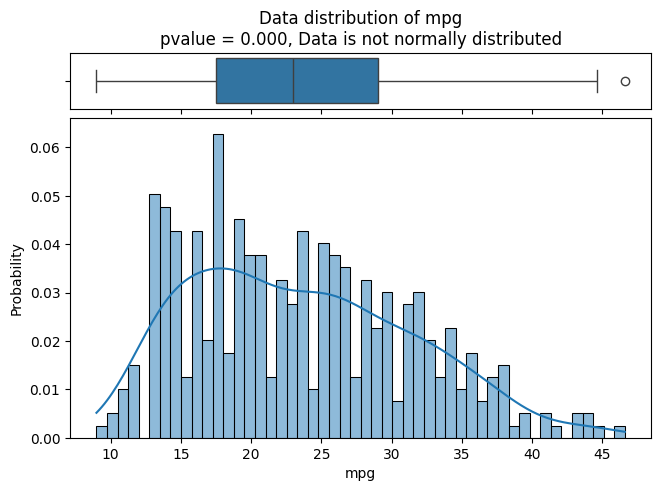

In [9]:
plot_distribution('mpg')

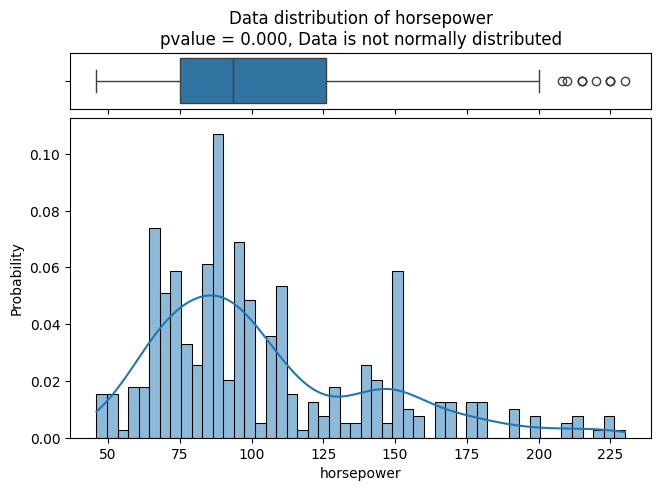

In [10]:
plot_distribution('horsepower')

**Insight**

- The mpg and horsepower variables are not normally distributed.

`Graphical Summary`

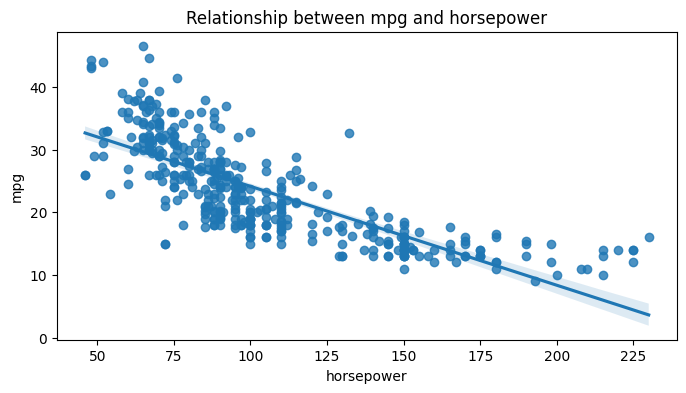

In [11]:
plt.figure(figsize=(8,4))
sns.regplot(data=data, y='mpg', x='horsepower')
plt.title('Relationship between mpg and horsepower')
plt.show()

**Insight**:

- There is a negative relationship between horsepower and mpg. The higher the horsepower, the lower the mpg (greater fuel consumption).

`Correlation`

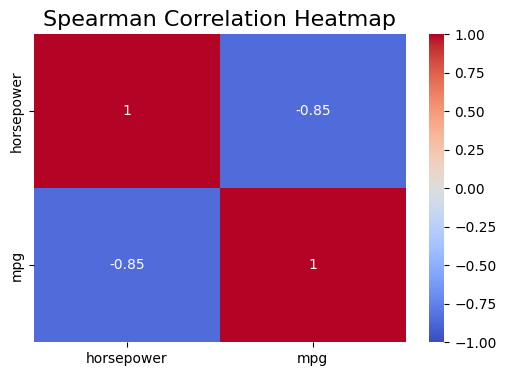

In [12]:
plt.figure(figsize=(6,4))
sns.heatmap(data.corr('spearman'), annot=True, vmin=-1, vmax=1, cmap='coolwarm')

plt.title('Spearman Correlation Heatmap', fontsize=16)
plt.show()

**Insight**:

- There is a strong correlation between mpg and horsepower, with a correlation value of 0.85.

### `Data Preparation`

**Duplicated Value**, Detection and quantification of data duplication

In [13]:
print(f"Number of duplicate data: {data[data.duplicated()].shape}")

Number of duplicate data: (60, 2)


About 15% of the data is indicated as duplicate. We will remove one of them.

Handling data duplication:

In [14]:
data.drop_duplicates(keep='last', inplace=True, ignore_index=True)

**Missing Value**, Detection and quantification of missing values

In [16]:
pd.DataFrame({'Missing values': [data[col].isna().sum() for col in data.columns]}, index=data.columns.values)

,Missing values
horsepower,6
mpg,0


The variable (horsepower) contains 6 data points or about 1.5% missing values.

Handling missing value:

In [17]:
data.dropna(inplace=True)

Sanity check:

In [18]:
pd.DataFrame({'Missing values': [data[col].isna().sum() for col in data.columns]}, index=data.columns.values)

,Missing values
horsepower,0
mpg,0


**Outlier**, Outlier detection and quantification

An outlier is a data point that differs significantly from the rest of the data. Linear models, especially linear regression, are sensitive to outliers. Therefore, we need to detect and handle outliers.

First, try detecting and quantifying outliers univariately.

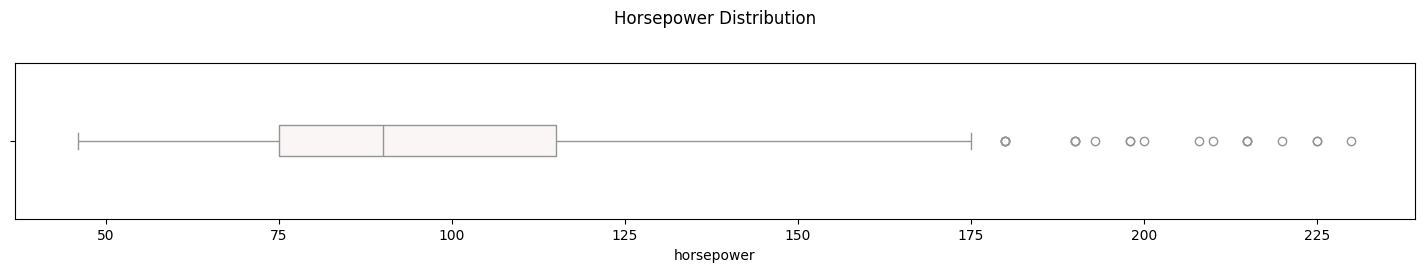

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(20,2))
plt.title('Horsepower Distribution', y=1.2)

sns.boxplot(x='horsepower', data=data, width=0.2, palette="vlag", ax=ax)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, wspace=0.1, hspace=0.4)
plt.show()

In [20]:
def n_outlier(data):
    q1, q3 = data.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - iqr * 1.5
    upper = q3 + iqr * 1.5

    n = len(data)
    n_upper = len(np.where(data > upper)[0])/n
    n_lower = len(np.where(data < lower)[0])/n
    print(f'Percentage: {round((n_upper + n_lower)*100, 2)}')
    return lower, upper

lower, upper = n_outlier(data['horsepower'])

Percentage: 6.02


**Insight**
- The distribution of the horsepower variable is asymmetrical
- Skewness is more skewed to the right or positive
- Based on the IQR limits, approximately 6.02 is identified as an outlier.
- If the outlier percentage is above 5%, it will be temporarily retained.

**Feature Engineering**

Divide the dataset into y (target) and X (feature).

In [21]:
y = data['mpg']
X = sm.add_constant(data[['horsepower']])

### `Modeling`

**Benchmark Model**

In [22]:
# define model
linreg = sm.OLS(y, X)

# fitting
result = linreg.fit()

# print result
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     487.1
Date:                Sat, 06 Sep 2025   Prob (F-statistic):           6.01e-67
Time:                        23:49:27   Log-Likelihood:                -1003.9
No. Observations:                 332   AIC:                             2012.
Df Residuals:                     330   BIC:                             2019.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.3640      0.783     51.532      0.0

**Model Interpretation**

Equation:

$$\text{y} = \beta_{0} + \beta_{1} * \text{X}$$
$$\text{mpg} = 40.3640 - 0.1584 * \text{horsepower}$$

F-Test:

- `H0`: $\beta_{1}=0$. Horsepower has no significant effect on mpg
- `H1`: $\beta_{1}!=0$. Horsepower has a significant effect on mpg (There is at least one variable that has a significant effect on the target. But we don't know which one)
- $\alpha=0.05$
- Prob(F-Statistic): 6.01e-67
- p-value < 0.05. Reject `H0`.
- This means we have sufficient evidence that **horsepower has a significant effect on mpg**.

Partial Test:
- $\beta_{0}$: const (intercept)
- `H0`: $\beta_{0}=0$. The model does not require an intercept.
- `H1`: $\beta_{0}!=0$. The model requires an intercept.
- $\alpha=0.05$
- P>|t|: 0.000
- p-value < 0.05. Reject `H0`.
- This means we have sufficient evidence that the model requires an intercept.

- $\beta_{1}$: horsepower (slope)
- `H0`: $\beta_{1}=0$. Horsepower has no significant effect on mpg.
- `H1`: $\beta_{1}!=0$. Horsepower has a significant effect on mpg.
- $\alpha=0.05$
- P>|t|: 0.000
- p-value < 0.05. Reject `H0`.
- This means we have sufficient evidence that horsepower has a significant effect on mpg.

Parameter Estimate:
- $\beta_{0}= 40.364$. This means that when horsepower (X) is equal to 0, the mpg (y) is 40.364 miles per gallon. (This case is actually invalid, because X=0 falls outside the horsepower range between 46 and 230 hp. However, we know the model requires an intercept.)
- $\beta_{1}= -0.1584$. This means that when horsepower increases by 1 hp, mpg decreases by 0.1584 miles per gallon. This interpretation only applies to horsepower values ​​in the range of 46 and 230 hp.

Coefficient of Determination:
- R-squared: 0.596
- This model (which only uses horsepower) can explain 59.6% of the variation in mpg. The remaining 40.4% can be explained by other features not included in the model.

**Model Limitation**

- The interpretation of the coefficients above only applies to the horsepower range between 46 and 230 hp.

**Model Evaluation**

`Mean Squared Error`

In [23]:
y_pred = result.predict(X)

mean_squared_error(y, y_pred)

24.772524793883502

`Root Mean Squared Error`

In [24]:
root_mean_squared_error(y, y_pred)

4.977200497657644

### `Conclusion`

- Based on the modeling conducted, the mpg value is influenced by horsepower.

- The evaluation metrics used in the model are the MSE and RMSE values. The RMSE value generated by the model is 4.98, meaning that if this model is used to estimate mpg, the prediction will be off by +/- 4.98 from the expected mpg.
However, it is also possible that the prediction will be off by even more due to bias. The bias produced by this model is due to the limited features in the dataset that can represent mpg (other than horsepower).

- The model can explain 59.6% of the variation in mpg.